In [15]:
from math import sqrt
import re
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline
from pylab import * 
from itertools import product 


In [16]:
ls = range(1,6) #length of kmer
ys = [1, 2, 4, 5, 6, 10, 15] #some threshold
region = "data/region30_out/region30"

### Run profile kernel

In [3]:
for l, y in product(ls, ys):
    print(">>> Working on parameters L={0}, Y={1}".format(l, y))
    !profkernel-core -o {region}.idfile -K -L {l} -Y {y} -i /usr/share/fastprofkernel/data/Amino.txt -g /usr/share/fastprofkernel/data/Globals.txt {region}.kernelinput > {region}_L{l}_Y{y}.mat 2> {region}_L{l}_Y{y}.mat.log  

>>> Working on parameters L=1, Y=1
>>> Working on parameters L=1, Y=2
>>> Working on parameters L=1, Y=4
>>> Working on parameters L=1, Y=5
>>> Working on parameters L=1, Y=6
>>> Working on parameters L=1, Y=10
>>> Working on parameters L=1, Y=15
>>> Working on parameters L=2, Y=1
>>> Working on parameters L=2, Y=2
>>> Working on parameters L=2, Y=4
>>> Working on parameters L=2, Y=5
>>> Working on parameters L=2, Y=6
>>> Working on parameters L=2, Y=10
>>> Working on parameters L=2, Y=15
>>> Working on parameters L=3, Y=1
>>> Working on parameters L=3, Y=2
>>> Working on parameters L=3, Y=4
>>> Working on parameters L=3, Y=5
>>> Working on parameters L=3, Y=6
>>> Working on parameters L=3, Y=10
>>> Working on parameters L=3, Y=15
>>> Working on parameters L=4, Y=1
>>> Working on parameters L=4, Y=2
>>> Working on parameters L=4, Y=4
>>> Working on parameters L=4, Y=5
>>> Working on parameters L=4, Y=6
>>> Working on parameters L=4, Y=10
>>> Working on parameters L=4, Y=15
>>> Working 

### Adding row/col counts to the matrices

In [4]:
row_count = !wc -l {region}_L{ls[0]}_Y{ys[0]}.mat 
row_count = int(row_count[0].split(" ")[0])
row_count

876

In [5]:
for l, y in product(ls, ys):
    !echo "{row_count} {row_count}\n$(cat {region}_L{l}_Y{y}.mat)" > {region}_L{l}_Y{y}.2.mat

### Execute weka

In [6]:
for l, y in product(ls, ys):
    print(">>> Working on parameters L={0}, Y={1}".format(l, y))
    !java -Xmx5g -cp bin/wekaTobi.jar:bin/weka.jar: weka.classifiers.meta.CVParameterSelection -t {region}.arff -x 5 -S 1 -W weka.classifiers.functions.SMO -- -C 1.0 -L 0.0010 -P 1.0E-12 -N 0 -V -1 -W 1 -K "weka.classifiers.functions.supportVector.CustomPrecomputedKernelMatrixKernelFast -M {region}_L{l}_Y{y}.2.mat" > {region}_L{l}_Y{y}.weka

>>> Working on parameters L=1, Y=1
>>> Working on parameters L=1, Y=2
>>> Working on parameters L=1, Y=4
>>> Working on parameters L=1, Y=5
>>> Working on parameters L=1, Y=6
>>> Working on parameters L=1, Y=10
>>> Working on parameters L=1, Y=15
>>> Working on parameters L=2, Y=1
>>> Working on parameters L=2, Y=2
>>> Working on parameters L=2, Y=4
>>> Working on parameters L=2, Y=5
>>> Working on parameters L=2, Y=6
>>> Working on parameters L=2, Y=10
>>> Working on parameters L=2, Y=15
>>> Working on parameters L=3, Y=1
>>> Working on parameters L=3, Y=2
>>> Working on parameters L=3, Y=4
>>> Working on parameters L=3, Y=5
>>> Working on parameters L=3, Y=6
>>> Working on parameters L=3, Y=10
>>> Working on parameters L=3, Y=15
>>> Working on parameters L=4, Y=1
>>> Working on parameters L=4, Y=2
>>> Working on parameters L=4, Y=4
>>> Working on parameters L=4, Y=5
>>> Working on parameters L=4, Y=6
>>> Working on parameters L=4, Y=10
>>> Working on parameters L=4, Y=15
>>> Working 

### extract confusion matrix from WEKA

In [3]:
perf_dict = {}
for l, y in product(ls, ys):
    file = "{}_L{}_Y{}.weka".format(region, l, y)
    matrix = []
    with open(file) as f: 
        isMatrix = False
        isCV = False
        for line in f.readlines():         
            if line.startswith("=== Stratified cross-validation"):
                isCV = True
            if isCV and line.startswith("=== Confusion Matrix"):
                isMatrix = True
            if isMatrix and isCV: 
                matrix.append(line)
    pos = matrix[3].split("|")[0].strip()
    neg = matrix[4].split("|")[0].strip()
    TP, FN = (int(x.strip()) for x in pos.split())
    FP, TN = (int(x.strip()) for x in neg.split())
    perf_dict[(l, y)] = (TP, FN, FP, TN)

### compare the parameters
#### Which measure to use?
* Accuracy: bad because data is unbalanced
* F-Measure: hard to interpret intuitievely
* MCC: good, easy to interpret and balanced
* Sensistivity, Specificity: good, give the user information about what they actually expect from the predictor

In [13]:
def mcc(TP, FN, FP, TN): 
    return np.divide(TP * TN + FP * FN, sqrt( (TP+FP) * (TP+FN) * (TN+FP) * (TN+FN)))

def sens(TP, FN, FP, TN):
    return TP / (TP + FN)

def spec(TP, FN, FP, TN):
    return TN / (TN + FP)

def prec_pos(TP, FN, FP, TN):
    return np.divide(TP, (TP + FP))
def recall_pos(TP, FN, FP, TN):
    return np.divide(TP, (TP + FN))
def prec_neg(TP, FN, FP, TN):
    return np.divide(TN, (TN + FN))
def recall_neg(TP, FN, FP, TN):
    return np.divide(TN, (TN + FP))

def f1_pos(TP, FN, FP, TN):
    return np.divide(2 * prec_pos(TP, FN, FP, TN) * recall_pos(TP, FN, FP, TN),
                     (prec_pos(TP, FN, FP, TN) + recall_pos(TP, FN, FP, TN)))
def f1_neg(TP, FN, FP, TN):
    return np.divide(2 * prec_neg(TP, FN, FP, TN) * recall_neg(TP, FN, FP, TN),
                     (prec_neg(TP, FN, FP, TN) + recall_neg(TP, FN, FP, TN)))

In [7]:
def make_df(f):
    f_dict = {}
    for y in ys:
        f_dict[y] = {}
        for l in ls:
            f_dict[y][l] = f(*perf_dict[l, y])
    return pd.DataFrame(f_dict)

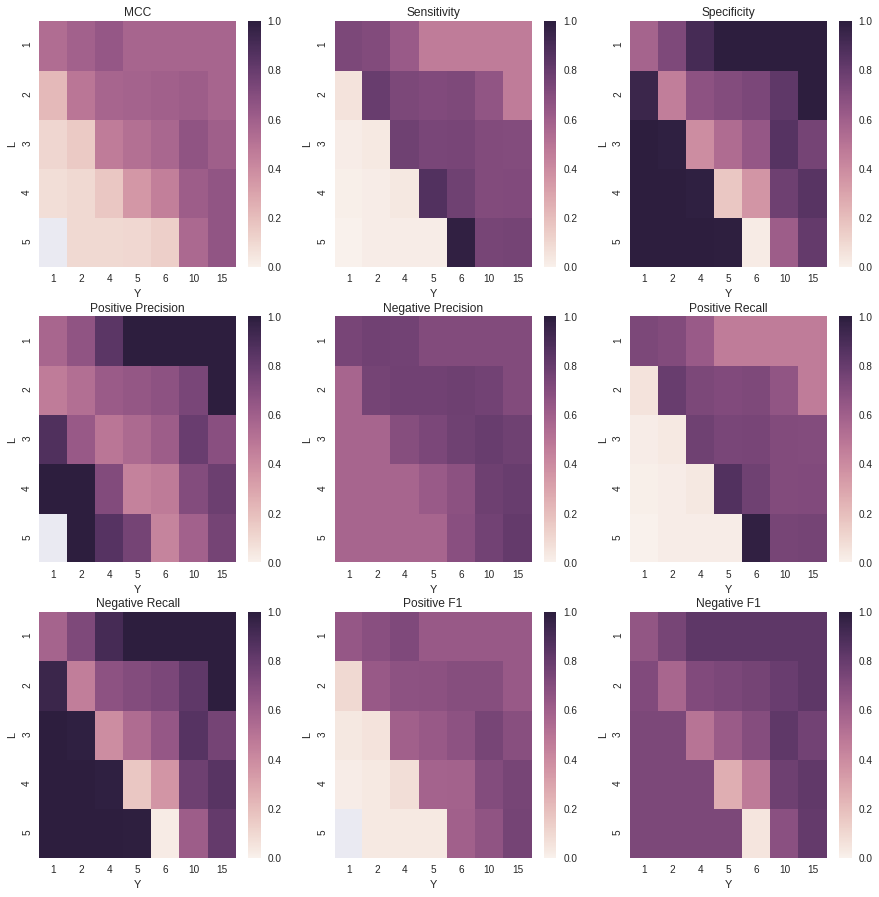

In [18]:
fig, grid = subplots(3, 3, figsize=(15, 15))

sns.heatmap(make_df(mcc), ax=grid[0][0], vmin=0, vmax=1)
grid[0][0].set_title("MCC")

sns.heatmap(make_df(sens), ax=grid[0][1], vmin=0, vmax=1)
grid[0][1].set_title("Sensitivity")

sns.heatmap(make_df(spec), ax=grid[0][2], vmin=0, vmax=1)
grid[0][2].set_title("Specificity")

sns.heatmap(make_df(prec_pos), ax=grid[1][0], vmin=0, vmax=1)
grid[1][0].set_title("Positive Precision")

sns.heatmap(make_df(prec_neg), ax=grid[1][1], vmin=0, vmax=1)
grid[1][1].set_title("Negative Precision")

sns.heatmap(make_df(recall_pos), ax=grid[1][2], vmin=0, vmax=1)
grid[1][2].set_title("Positive Recall")

sns.heatmap(make_df(recall_neg), ax=grid[2][0], vmin=0, vmax=1)
grid[2][0].set_title("Negative Recall")

sns.heatmap(make_df(f1_pos), ax=grid[2][1], vmin=0, vmax=1)
grid[2][1].set_title("Positive F1")

sns.heatmap(make_df(f1_neg), ax=grid[2][2], vmin=0, vmax=1)
grid[2][2].set_title("Negative F1")


for ax in grid.flatten():
    ax.set_xlabel("Y")
    ax.set_ylabel("L")
    
fig.savefig("wiki/eval30.png")

In [9]:
make_df(mcc)

,1,2,4,5,6,10,15
1,0.536057,0.590760,0.642347,0.576171,0.576171,0.576171,0.576171
2,0.220832,0.493644,0.571950,0.583564,0.601164,0.615213,0.576171
3,0.106888,0.152978,0.468340,0.521797,0.565314,0.662928,0.602861
4,0.078102,0.095765,0.164821,0.350120,0.456122,0.615139,0.659614
5,NaN,0.095765,0.099476,0.103179,0.139748,0.552661,0.658670


#### try roc curve

In [10]:
df_sens = make_df(sens)
df_spec = make_df(spec)

In [11]:
sns = []
sps = []
for i, row in df_sens.iterrows():
    for sn in row:
        sns.append(sn)
for i, row in df_spec.iterrows():
    for sp in row:
        sps.append(1-sp)

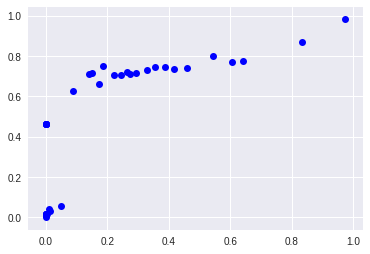

In [12]:
scatter(sps, sns)